# Moment Tensor Amplitude Inversion
## The inverse crime edition

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp


In [2]:
from pyfrac.mtsolvers.homo_mti import collect_source_angles, pwave_Greens_comp
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict
from pyfrac.mtsolvers.mtai import *

from pyfrac.visualisation.eventimages import locimage3d
from pyfrac.visualisation.momenttensor_plots import MTMatrix_comparisonplot, MTBeachball_comparisonplot

# 3D Model - Homo

In [3]:
# Velocity Model
nx, ny, nz = 47, 51, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 143)
[[  4.  180.  162.4 144.8 127.2 109.6  92.   74.4  56.8  39.2  21.6   4.
  180.  162.4 144.8]
 [  4.    4.   20.   36.   52.   68.   84.  100.  116.  132.  148.  164.
  164.  180.  196. ]
 [  4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.
    4.    4.    4. ]]
[  4.  20.  36.  52.  68.  84. 100. 116. 132. 148. 164. 180. 196.] 200 [  4.   21.6  39.2  56.8  74.4  92.  109.6 127.2 144.8 162.4 180. ] 184


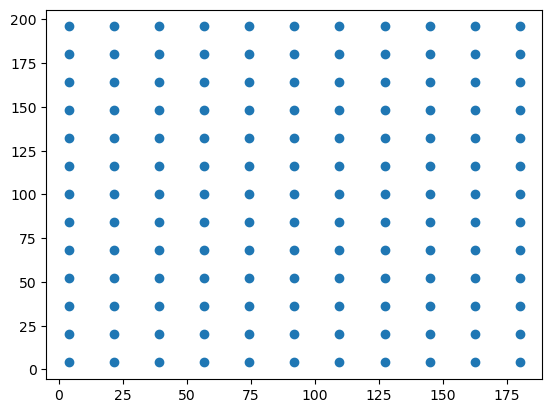

In [4]:
# RECEIVERS
grid_rx_locs = np.linspace(dx, (dx*nx)-2*dx, 11)
grid_ry_locs = np.linspace(dy, (dy*ny)-2*dy, 13)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])
print(grid_ry_locs, y.max(), grid_rx_locs, x.max())

## Get all necessary components

In [5]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [6]:
# Source Parameters
omega_p = 30  # Assume central frequency of 25Hz
sloc_ind = [nx//2, ny//2, nz//2]  # As indices of velocity model

In [7]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for area of interest

In [8]:
Gz = pwave_Greens_comp(gamma_sourceangles,
                        dist_table,
                        sloc_ind,
                        vel,
                        MT_comp_dict,
                        comp_gamma_ind=2,
                        omega_p=omega_p,
                        )

In [9]:
Gz.shape

(6, 143)

# Single Event Example

In [10]:
# Modelled MT
mt =-1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 

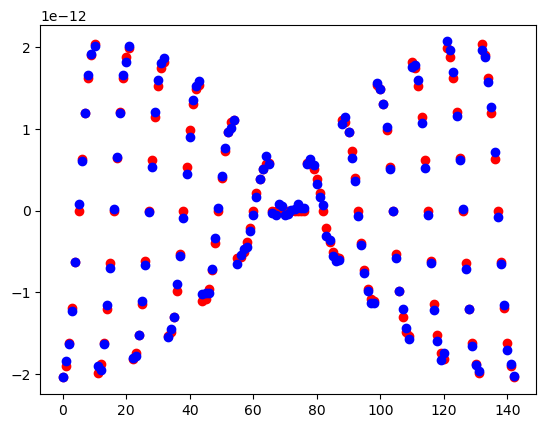

In [11]:
# Forward
p_amps = frwrd_mtmodelling(Gz, mt)
plt.scatter(x=np.arange(len(p_amps)), y=p_amps, c='r')
p_amps += 0.2*((np.random.random(len(p_amps))-0.5)*np.mean(abs(p_amps)))
plt.scatter(x=np.arange(len(p_amps)), y=p_amps, c='b')

[ 8.59912702e-03  2.57542367e-04 -1.41983806e-03 -1.00343096e+00
  6.50154997e-04  1.91496126e-03]
[-0.00859913 -0.00025754  0.00141984  0.00343096 -0.00065015 -0.00191496]


Text(0.5, 1.0, 'MT Amplitude Inversion')

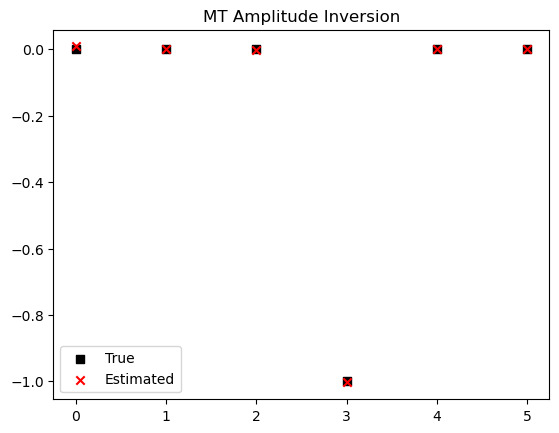

In [12]:
# LSQR Inversion
mt_est = lsqr_mtsolver(Gz, p_amps)
print(mt_est)
print(mt-mt_est)

plt.scatter(range(6), mt, c='k', marker='s', label='True')
plt.scatter(range(6), mt_est, c='r', marker='x', label='Estimated')
plt.legend()
plt.title('MT Amplitude Inversion')

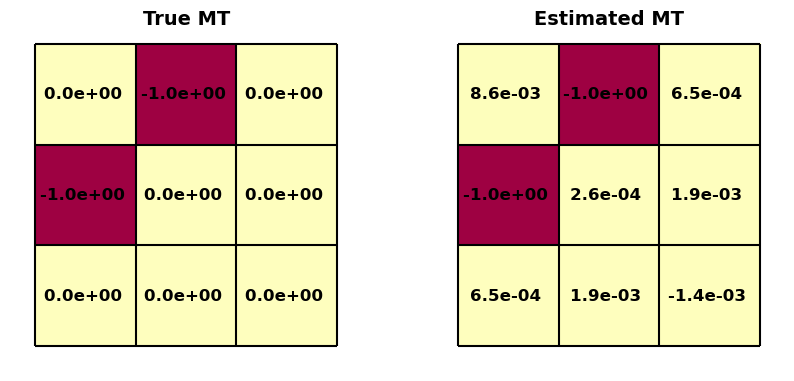

In [16]:
MTMatrix_comparisonplot(mt,mt_est)

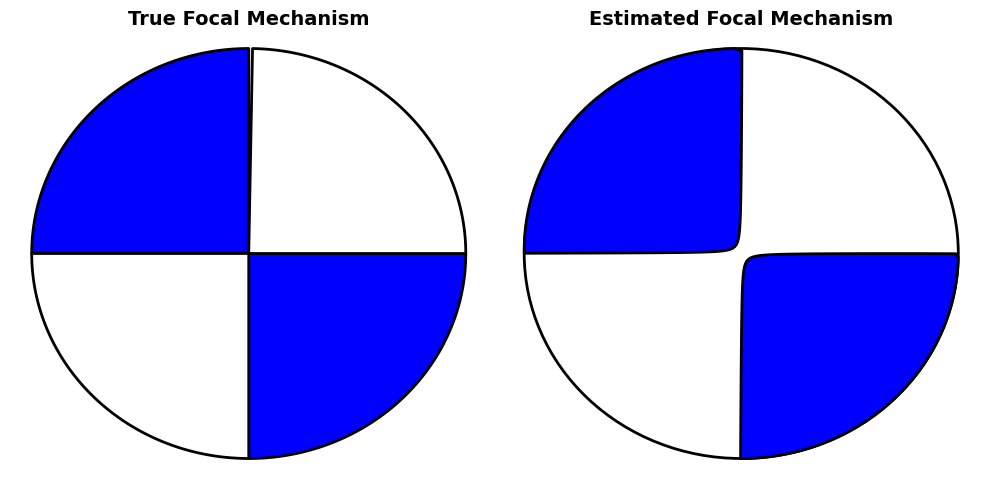

In [14]:
MTBeachball_comparisonplot(mt, mt_est)